## **DS4A_2020 | Modeling - MINJUSTICIA & CRIME RECIDIVISM IN COLOMBIA CASE STUDY**

**Business Context.** 
Recidivism is a measure of a former prisoner's likelihood to be re-arrested, re-convicted, or returned to prison with or without a new sentence during a three-year period following the prisoner's release. It has been used to study the performance and effectiveness of privately and publicly managed prisons (DS4A Colombia 2.0, 2020). 

According to the report “Séptimo informe semestral del estado de seguimiento al estado de cosas Inconstitucional del Sistema Penitenciario y Carcelario” the average recidivism in Colombia in the last 7 years is 27.3%, with an upward trend. The benefits that the Colombian Ministry of Justice could derive from the identification of patterns of recidivism are linked to the development of public policies for the prevention and re-socialization of the population confined in prisons. This is an intangible benefit that acquires greater value if it is applied, for example, in detention centers for the development of programs of counseling, training and treatment of offenders (semi-customized) or if it is used as a criteria for sentence enforcement judges to assess their decisions with a greater degree of objectivity (for example the benefits of extramural detention). 

**Business Problem.**
The main objective is the “characterization of the recidivist population of the Penitentiary and Prison System in Colombia. This information is key to have inputs for the formation and monitoring of the criminal policy of the Colombian State in its phases of prevision and tertiary criminalization”. It is also important to highlight that this objective is framed in the National Plan of Criminal Policy 2019 - 2022 of the Colombian state, which has among its expected results the reduction of recidivism.

Addressing the problem of recidivism is primarily essential to prevent crime (and consequently prison overcrowding). In addition, it supports a better implementation of resocialization treatments that characterize the convicted population susceptible to recidivism, changing the focus from punishment to semi-personalized rehabilitation programs. Even more important is the increase in public security levels.

**Analytical Context.**
The main dataset is derived from a database containing records of Recidivist and Non-Recidivist individuals curated by the Ministry of Justice and Law. This database consists of different tabular datasets which were merged into a single dataset and mounted into Amazon RDS SQL database. 

The activities shown in this notebook are related to the modeling exercises conducted with the above dataset.


## IMPORTING LIBRARIES

In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import os
import seaborn as sns
from wordcloud import WordCloud 
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import statsmodels.api as sm

from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split ,  KFold
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
import pickle

## DATASET

In [2]:
engine = create_engine('')
df = pd.read_sql('select * from reincidentes', engine)

In [3]:
df_cluster = pd.read_csv('Clusters.csv')

In [3]:
#unique values per column
for i, col in enumerate(df.columns):
  print('Column: ' ,col)
  print('Type: ' , df.dtypes.iloc[i])
  print('Valores unicos:  ' , len(df[col].unique()))
  print('NaN values: ' , df[col].isna().sum())
  print()
  print('Unique values:')
  print(df[col].value_counts())
  print()
  if (df.dtypes.iloc[i] == 'int64') |(df.dtypes.iloc[i] == 'float64') | (df.dtypes.iloc[i] == 'float32') |(df.dtypes.iloc[i] == 'int32')  :
    print()
    print('Min: ', df[col].min() , '    Avg: ', df[col].mean() , '    Max: ' , df[col].max() )
    print()
  print('-------------------------------------------------------------')
  print()


Column:  interno
Type:  object
Valores unicos:   246031
NaN values:  0

Unique values:
C72340BA10058948D7502977EBD24271FE13FFBC    23
F0A6DB3801F271962A6ECE4758C2413FDCBAA9AE    23
8D0B78EB1B142BEA8E3B9D2DA5287A650657CA6A    19
2A7200F4FB3939FBC271C6CB333026C1C6A69B6B    17
DC30870A593EC471BCE781F51D1724ABCCE2A502    16
                                            ..
CE222D241E26AA821FCC98D92A199E30812F9E3C     1
6A3CBC52FD4EA0DC8297C8B576BAA95BDAFF70DF     1
B4DA5C363BFD5825FA3F059070D79AC4EB9D59CC     1
2C78F5C1C568AF15675EDDECB9668B533C30D1CB     1
97B5796FEF1DD7ABBBC69BCA5746A51D726111E4     1
Name: interno, Length: 246031, dtype: int64

-------------------------------------------------------------

Column:  delito
Type:  object
Valores unicos:   321
NaN values:  0

Unique values:
HURTO                                                                           97495
TRAFICO FABRICACION O PORTE DE ESTUPEFACIENTES                                  75174
FABRICACION TRAFICO Y PORTE DE AR

***DATA TYPES TRANSFORMATIONS***

In [4]:
# to datetime
df_cluster['FECHA_INGRESO'] = pd.to_datetime(df_cluster['FECHA_INGRESO'], format = '%Y-%m-%d')

df['fecha_captura'] = pd.to_datetime(df['fecha_captura'], format = '%Y-%m-%d')
df['fecha_ingreso'] = pd.to_datetime(df['fecha_ingreso'], format = '%Y-%m-%d')
df['fecha_salida'] = pd.to_datetime(df['fecha_salida'], format = '%Y-%m-%d')
df['edad'] =  (df['fecha_ingreso'] - pd.to_datetime(df['ano_nacimiento'] , format = '%Y' ))/np.timedelta64(1,'Y')  

df['sentencia'] = (df['fecha_salida'] - df['fecha_ingreso'])/np.timedelta64(1,'Y')
df['sentencia'] = df['sentencia'].apply(lambda x: x if x > 0 else np.nan)
#Columns adjustments
df['hijos_menores'] = [x if x in ['SI','NO'] else 'NO' if x == 0 else 'SI' for x in df['hijos_menores']]
df.condic_expecional = df.condic_expecional.fillna('Ninguno')
df.estado_civil = df.estado_civil.fillna('Ninguno')

#Using the variable condic_expecional (which had many possible categories) we will create 6 binary variables that group the information
df['AFRO'] = [1 if 'AFRO' in x else 0 for x in df['condic_expecional']]
df['INDIGENA'] = [1 if 'INDIGENA' in x else 0 for x in df['condic_expecional']]
df['ADULTO_MAYOR'] = [1 if 'ADULTO' in x else 0 for x in df['condic_expecional']]
df['LGBTI'] = [ 1 if any(y in x for y in ['GAY','LESBIANA','TRANSEX','BISEX','INTERSEX']) else 0 for x in df['condic_expecional'] ]
df['DISCAPACITADO'] = [ 1 if 'DISCAPACI' in x else 0 for x in df['condic_expecional'] ]
df['MADRE_LACT_GEST'] = [ 1 if any(y in x for y in ['MADRE GESTANTE','MADRE LACTANTE']) else 0 for x in df['condic_expecional'] ]

#Transform the object types into categorical
cat_variables = ['reincidente','tentativa','agravado','calificado','genero','estado_civil','estado_ingreso','actividades_trabajo','actividades_estudio','actividades_ensenanza','nivel_educativo','hijos_menores','regional','estado','AFRO','INDIGENA','ADULTO_MAYOR','LGBTI','DISCAPACITADO','MADRE_LACT_GEST']
for i in cat_variables:
    df[i] = df[i].astype('category')

df.actividades_trabajo = df.actividades_trabajo.astype(pd.api.types.CategoricalDtype(categories=[ 'NO' ,'SI'] , ordered=False))
df.actividades_estudio = df.actividades_estudio.astype(pd.api.types.CategoricalDtype(categories=['NO' ,'SI'] , ordered=False))
df.actividades_ensenanza = df.actividades_ensenanza.astype(pd.api.types.CategoricalDtype(categories=['NO' ,'SI'] , ordered=False))
df.hijos_menores = df.hijos_menores.astype(pd.api.types.CategoricalDtype(categories=['NO' ,'SI'] , ordered=False))

#Ordered cat variables
df.nivel_educativo = df.nivel_educativo.astype(pd.api.types.CategoricalDtype(categories=['ANALFABETA', 'CICLO I', 'CICLO II', 'CICLO III', 'CICLO IV', 'TECNOLOGICO','TECNICO','TECNICO PROFESIONAL', 'PROFESIONAL','POST GRADO','ESPECIALIZACION','MAGISTER'] , ordered=True))

***DOWNCASTING***<br>
This is the process of downgrading the size of memory of the columns with float and int data type, so for the analysis and modelling process, it will be less resource-consuming

In [5]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df
df = downcast_dtypes(df)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365339 entries, 0 to 365338
Data columns (total 37 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   interno                 365339 non-null  object        
 1   delito                  365339 non-null  object        
 2   tentativa               365339 non-null  category      
 3   agravado                365339 non-null  category      
 4   calificado              365339 non-null  category      
 5   fecha_ingreso           365339 non-null  datetime64[ns]
 6   fecha_salida            318622 non-null  datetime64[ns]
 7   fecha_captura           365339 non-null  datetime64[ns]
 8   situacion_juridica      365339 non-null  object        
 9   ano_nacimiento          365331 non-null  float32       
 10  edad                    365331 non-null  float32       
 11  genero                  365339 non-null  category      
 12  estado_civil            365339

**Data adjustments**

The data available contains one line for each convict-entrydate-crime. Fitting a model with the information in that structure could generate bias since there is more than one observation for each convict. Before starting working on the features/fitting models we decided to group the data by Convict and entry_date.

In order to have more information to feed into the models during this week we build the following features:

After grouping the information by convict and entry_date, the features ‘tentativa’, ‘agravado’ and ‘calificado’ had to be recalculated since they are linked to each crime. The ‘tentativa’ feature will be ‘Si’ in case every crime committed by the convict had ‘tentativa’ as ‘Si’. For ‘agravado’ and ‘calificado’ features, they will be ’No’ in case all the crimes committed by the convict are not ‘agravado’ and ‘calificado’ respectively, otherwise will be ‘Si’.
After grouping the information by convict and entry_date we were able to calculate a new feature called ‘cuenta_delitos’ which is the number of crimes committed by the convict on the entry date.
The information contained in the feature ‘condic_expecional’ had many categories that were not easy to feed into a model. We extracted the information on this feature to create 6 new binary features:  ‘AFRO’, 'INDIGENA', ADULTO_MAYOR', 'LGBTI' ,'DISCAPACITADO' and 'MADRE_LACT_GEST'.
We built a prison time feature using the entry and release date for the prisoners. 
An independence test is carried out for each of the variables, in order to establish whether or not there is any relationship between each of the variables and recidivism or not.

We believe that some of these features may help the models we will fit to have a better performance.


In [6]:
#Sort the df leaving the oldest process date first
df = df.sort_values(by=['fecha_ingreso'] , ascending= True)
df.reset_index(inplace = True , drop = True)
#Groups the df by interno,fecha_ingreso and concatenates the crimes commited, calculates the grouped values for tentativa, agravado and alificado 
df_groupedcrimes = df.groupby(['interno','fecha_ingreso']).agg(
    delitos = ('delito', lambda x: ' -- '.join(x)),
    tentativa = ( 'tentativa' , lambda x: 'N' if 'N' in ''.join(x) else 'S' ),
    agravado = ( 'agravado' , lambda x: 'S' if 'S' in ''.join(x) else 'N' ),
    calificado = ( 'calificado' , lambda x: 'S' if 'S' in ''.join(x) else 'N')) 
df_groupedcrimes['tentativa'] = df_groupedcrimes['tentativa'].astype('category')
df_groupedcrimes['agravado'] = df_groupedcrimes['agravado'].astype('category')
df_groupedcrimes['calificado'] = df_groupedcrimes['calificado'].astype('category')

#df_groupedcrimes = df.groupby(['interno','fecha_ingreso'])['delito'].apply(lambda x: ' -- '.join(x)).reset_index()
#Groups the df by interno,fecha_ingreso and calculate the number of crimes comitted on that entry
df_crime_count = df.groupby(['interno','fecha_ingreso']).agg({'interno':'count'}).rename(columns = {'interno':'cuenta_delitos'}).reset_index()
##Merges the two df
crimes = pd.merge(df_groupedcrimes, df_crime_count , on = ['interno','fecha_ingreso'])
#Merges adds the intern count to the main df, then drops the delito column because this information is contained in the delitos column
df_no_duplic= pd.merge(df.drop(columns=['tentativa','agravado','calificado','delito']) , crimes , how = 'left' , on = ['interno','fecha_ingreso'])
#Drops duplicates for interno and fecha ingreso in order to end with only one line for each intern/fecha_ingreso and all the crimes asociated to that entry
df_no_duplic = df_no_duplic.drop_duplicates(subset=['interno','fecha_ingreso'], keep="first")
#Group by interno to chek hoy many times interns have been processed
df_entradas = df_no_duplic.groupby('interno').agg({'interno':'count'}).rename(columns = {'interno':'ingresos'})
#Adds the 'entradas' variable to the main df
df_no_duplic = pd.merge( df_no_duplic , df_entradas , how = 'left' , left_on = 'interno' ,  right_index= True)

#Cat vars order
df_no_duplic.tentativa = df_no_duplic.tentativa.astype(pd.api.types.CategoricalDtype(categories=['N', 'S'] , ordered=False))
df_no_duplic.agravado = df_no_duplic.agravado.astype(pd.api.types.CategoricalDtype(categories=['N', 'S'] , ordered=False))
df_no_duplic.calificado = df_no_duplic.calificado.astype(pd.api.types.CategoricalDtype(categories=['N', 'S'] , ordered=False))

In [7]:
##Merge with the clusters
df_no_duplic = pd.merge( df_no_duplic , df_cluster , how = 'inner' , left_on= ['interno','fecha_ingreso'] , right_on = ['INTERNO','FECHA_INGRESO'])

Porcentaje vacio: 0.0

Valores posibles:  6
% Ocurrencia:
CENTRAL         0.338633
OCCIDENTE       0.201847
NOROESTE        0.143623
VIEJO CALDAS    0.121634
ORIENTE         0.101242
NORTE           0.093020
Name: regional, dtype: float64


<AxesSubplot:xlabel='regional', ylabel='count'>

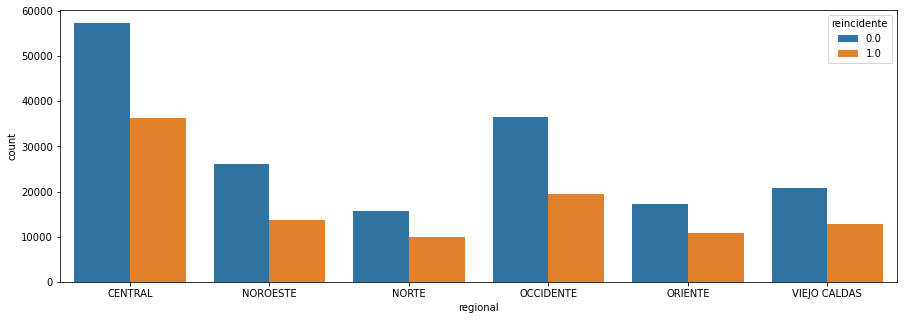

In [41]:
#Quick Validation of categorical columns
column = 'regional'
print('Porcentaje vacio:' ,df_no_duplic[column].isna().sum()/len(df_no_duplic[column]) )
print()
print('Valores posibles: ', len(df_no_duplic[column].unique())  )
print('% Ocurrencia:' )
print(df_no_duplic[column].value_counts()/len(df_no_duplic[column]) )

plt.figure(figsize=(15,5))
sns.countplot( x = column , hue = 'reincidente'  ,data = df_no_duplic)

**Modeling**

In [8]:
vars_filter = ['reincidente','tentativa',	'agravado'	, 'calificado', 'edad','genero','estado_civil' ,'estado_ingreso' ,'actividades_trabajo','actividades_estudio','actividades_ensenanza'  ,'nivel_educativo','hijos_menores','AFRO' , 'INDIGENA' , 'ADULTO_MAYOR' ,'LGBTI','DISCAPACITADO','MADRE_LACT_GEST','regional','cuenta_delitos' , 'sentencia', 
 'CLUSTER_0', 'CLUSTER_1', 'CLUSTER_2', 'CLUSTER_3', 'CLUSTER_4','CLUSTER_5', 'CLUSTER_6', 'CLUSTER_7', 'CLUSTER_8', 'CLUSTER_9','CLUSTER_10', 'CLUSTER_11', 'CLUSTER_12',
 'CLUSTER_0_TENTATIVA','CLUSTER_1_TENTATIVA', 'CLUSTER_2_TENTATIVA', 'CLUSTER_3_TENTATIVA',
 'CLUSTER_4_TENTATIVA', 'CLUSTER_5_TENTATIVA', 'CLUSTER_6_TENTATIVA',
'CLUSTER_7_TENTATIVA', 'CLUSTER_8_TENTATIVA', 'CLUSTER_9_TENTATIVA',
'CLUSTER_10_TENTATIVA', 'CLUSTER_11_TENTATIVA', 'CLUSTER_12_TENTATIVA',
'CLUSTER_0_AGRAVADO', 'CLUSTER_1_AGRAVADO', 'CLUSTER_2_AGRAVADO',
'CLUSTER_3_AGRAVADO', 'CLUSTER_4_AGRAVADO', 'CLUSTER_5_AGRAVADO',
'CLUSTER_6_AGRAVADO', 'CLUSTER_7_AGRAVADO', 'CLUSTER_8_AGRAVADO',
'CLUSTER_9_AGRAVADO', 'CLUSTER_10_AGRAVADO', 'CLUSTER_11_AGRAVADO',
'CLUSTER_12_AGRAVADO', 'CLUSTER_0_CALIFICADO', 'CLUSTER_1_CALIFICADO',
'CLUSTER_2_CALIFICADO', 'CLUSTER_3_CALIFICADO', 'CLUSTER_4_CALIFICADO',
'CLUSTER_5_CALIFICADO', 'CLUSTER_6_CALIFICADO', 'CLUSTER_7_CALIFICADO',
'CLUSTER_8_CALIFICADO', 'CLUSTER_9_CALIFICADO', 'CLUSTER_10_CALIFICADO',
'CLUSTER_11_CALIFICADO', 'CLUSTER_12_CALIFICADO']

#Filters the main datafdrame keeping the columns of interest
#df_filtered = df[vars_filter].dropna(subset=['edad','estado_ingreso']).copy() #All lines, the same intern could be twice in the df (multiple entries)
#Only the last entry for each intern 
df_filtered = df_no_duplic.sort_values(by=['fecha_ingreso'] , ascending= True).drop_duplicates(subset='interno', keep="last")[vars_filter].dropna(subset=['edad','estado_ingreso','sentencia']).copy() 

##Analizar si este enalisis es valido
#Generates another df that will be used in the future to perform additional tests over the models. This df has the information of the interns that have more than 1 entry
#df_filtered_testPost = df[df['ingresos']>1].drop_duplicates(subset='interno', keep="last")[vars_filter].dropna(subset=['edad','estado_ingreso']).copy()

**Class balancing**

Since our classes (reincidente / no reincidente) are not balanced (30-70), we will downsample the mayority class by randomly selecting observations of the 'no reindicente' class.

In [9]:
# Separate majority and minority classes
df_majority = df_filtered[ df_filtered['reincidente'] == 0 ]
df_minority = df_filtered[df_filtered['reincidente'] == 1 ]
# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                 replace=False,    # sample without replacement
                                 n_samples= len(df_minority) ,     # to match minority class
                                 random_state=0) # reproducible results
 # Combine minority class with downsampled majority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])
 # Display new class counts
df_balanced.reincidente.value_counts()

1.0    46298
0.0    46298
Name: reincidente, dtype: int64

In [10]:
df_models = pd.concat([ df_balanced['edad'],
                        df_balanced['sentencia'], #Is this information correct? max 10 years?
                        df_balanced['cuenta_delitos'],
                        pd.get_dummies(df_balanced['regional'], prefix='regional', drop_first= False),
                        #pd.get_dummies(df_balanced['estado_civil'], prefix='estado_civil'), #Most of this feature is empty 'ninguno'
                        pd.get_dummies(df_balanced['estado_ingreso'], prefix='estado_ingreso' , drop_first= True)
                        ]
                     , axis=1)
df_models['tentativa'] = df_balanced['tentativa'].cat.codes
df_models['agravado'] = df_balanced['agravado'].cat.codes
df_models['calificado'] = df_balanced['calificado'].cat.codes
df_models['genero'] = df_balanced['genero'].cat.codes
df_models['actividades_trabajo'] = df_balanced['actividades_trabajo'].cat.codes
df_models['actividades_estudio'] = df_balanced['actividades_estudio'].cat.codes
df_models['actividades_ensenanza'] = df_balanced['actividades_ensenanza'].cat.codes
df_models['hijos_menores'] = df_balanced['hijos_menores'].cat.codes
df_models['nivel_educativo'] = df_balanced['nivel_educativo'].cat.codes
df_models['AFRO'] = df_balanced['AFRO']
df_models['INDIGENA'] = df_balanced['INDIGENA']
df_models['ADULTO_MAYOR'] = df_balanced['ADULTO_MAYOR']
df_models['LGBTI'] = df_balanced['LGBTI']
df_models['DISCAPACITADO'] = df_balanced['DISCAPACITADO']
df_models['MADRE_LACT_GEST'] = df_balanced['MADRE_LACT_GEST']
#Clusters of crime commited
df_models['CLUSTER_0'] = df_balanced['CLUSTER_0']
df_models['CLUSTER_1'] = df_balanced['CLUSTER_1']
df_models['CLUSTER_2'] = df_balanced['CLUSTER_2']
df_models['CLUSTER_3'] = df_balanced['CLUSTER_3']
df_models['CLUSTER_4'] = df_balanced['CLUSTER_4']
df_models['CLUSTER_5'] = df_balanced['CLUSTER_5']
df_models['CLUSTER_6'] = df_balanced['CLUSTER_6']
df_models['CLUSTER_7'] = df_balanced['CLUSTER_7']
df_models['CLUSTER_8'] = df_balanced['CLUSTER_8']
df_models['CLUSTER_9'] = df_balanced['CLUSTER_9']
df_models['CLUSTER_10'] = df_balanced['CLUSTER_10']
df_models['CLUSTER_11'] = df_balanced['CLUSTER_11']
df_models['CLUSTER_12'] = df_balanced['CLUSTER_12']

#Interactions
df_models['CLUSTER_2_AGRAVADO'] = df_balanced['CLUSTER_2_AGRAVADO']
df_models['CLUSTER_4_TENTATIVA'] = df_balanced['CLUSTER_4_TENTATIVA']
df_models['CLUSTER_5_TENTATIVA'] = df_balanced['CLUSTER_5_TENTATIVA']
df_models['CLUSTER_5_AGRAVADO'] = df_balanced['CLUSTER_5_AGRAVADO']


#Transform everything to float
df_models = df_models.astype(float)

---

**Feature selection**

In [11]:
#Train and test split for feature selection
x_train, x_test, y_train, y_test = train_test_split(df_models, df_balanced[['reincidente']], test_size=0.2 , random_state=0)

#Standarization
#training_mean = x_train.mean()
#training_std =  x_train.std()
# Center data (common practice when using regularization techniques)
#x_train = (x_train - training_mean) / training_std # normalize (use training mean and training std)
#x_test = (x_test - training_mean) / training_std # normalize (use training mean and training std)

print('Train: ', x_train.shape)
print('Test: ', x_test.shape)

Train:  (74076, 46)
Test:  (18520, 46)


In [16]:
#Logit model with all variables to check significance
model_logit_full = sm.Logit(y_train , x_train).fit( n_jobs=-1 ,  method='bfgs')
model_logit_full.summary()

         Current function value: 0.618839
         Iterations: 35
         Function evaluations: 40
         Gradient evaluations: 40
C:\Users\Usuario\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            reincidente   No. Observations:                74076
Model:                          Logit   Df Residuals:                    74030
Method:                           MLE   Df Model:                           45
Date:                Thu, 30 Jul 2020   Pseudo R-squ.:                  0.1072
Time:                        16:02:59   Log-Likelihood:                -45841.
converged:                      False   LL-Null:                       -51346.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
edad                                      0.0122      0.001     13.958      0.000       0.010       0.014
sentencia                                -0.1464      0.006    -25.727      0.000      -0.158      -0.135
cuenta_delitos                            0.1455      0.020      7.180      0.000       0.106       0.185
regional_CENTRAL                         -0.5718      0.563     -1.015      0.310      -1.676       0.532
regional_NOROESTE                        -0.6776      0.563     -1.202      0.229      -1.782       0.427
regional_NORTE                           -0.3774      0.564     -0.669      0.503      -1.483       0.728
regional_OCCIDENTE                       -0.6467      0.564     -1.148      0.251      -1.751       0.458
regional_ORIENTE                         -0.5573      0.564     -0.988      0.323      -1.662       0.548
regional_VIEJO CALDAS                    -0.5348      0.564     -0.949      0.343      -1.640       0.570
estado_ingreso_Detencion Domiciliaria    -0.5099      0.562     -0.908      0.364      -1.611       0.591
estado_ingreso_Espera Traslado            0.2858      0.614      0.465      0.642      -0.918       1.490
estado_ingreso_Intramuros                -1.3504      0.561     -2.405      0.016      -2.451      -0.250
estado_ingreso_Prision Domiciliaria      -0.8497      0.561     -1.513      0.130      -1.950       0.251
estado_ingreso_Vigilancia Electronica    -0.9266      0.563     -1.647      0.100      -2.029       0.176
tentativa                                -0.0680      0.053     -1.280      0.200      -0.172       0.036
agravado                                  0.0364      0.027      1.374      0.169      -0.016       0.088
calificado                                0.2005      0.030      6.705      0.000       0.142       0.259
genero                                    0.3456      0.027     12.969      0.000       0.293       0.398
actividades_trabajo                       0.6790      0.017     39.519      0.000       0.645       0.713
actividades_estudio                       0.8998      0.019     47.106      0.000       0.862       0.937
actividades_ensenanza                    -0.2116      0.051     -4.184      0.000      -0.311      -0.112
hijos_menores                            -0.1442      0.021     -6.994      0.000      -0.185      -0.104
nivel_educativo                          -0.0063      0.006     -1.093      0.274      -0.018       0.005
AFRO                                      0.6385      0.047     13.525      0.000       0.546       0.731
INDIGENA                                 -0.0383      0.086     -0.445      0.656      -0.207       0.130
ADULTO_MAYOR                              0.0137      0.059      0.231      0.817      -0.102       0.130
LGBTI                                     0.0463      0.094      0.495      0.621      -0.137       0.230
DISCAPACITADO                             0.3828      0.082  

Best lambda:  0.001
Max auc:  0.710881441729003


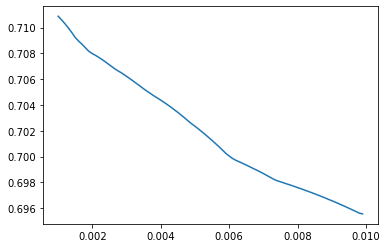

In [229]:
#Lasso feature selection
#Best lambda selection
lambdas = np.arange( 0.001, 0.01, 0.0001)
auc_test = []
for l in lambdas:
    lasso = linear_model.Lasso(alpha=l, fit_intercept=True)
    lasso.fit(x_train, y_train )
    roc_lasso = roc_curve(y_test , lasso.predict(x_test))
    auc_test.append( auc(roc_lasso[0], roc_lasso[1])) 
min_index=np.argmax(auc_test)
best_lambda = lambdas[min_index]
print('Best lambda: ' , best_lambda )
print( 'Max auc: ' ,  max(auc_test))
plt.plot( lambdas ,auc_test )

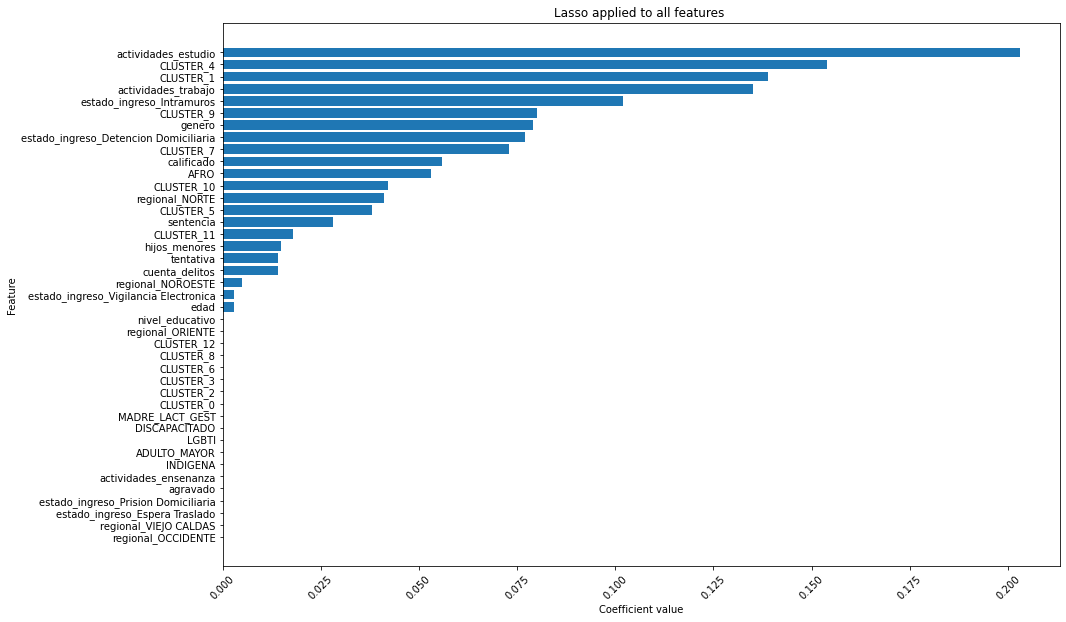

In [276]:
#Lasso using the best lambda found
lasso = linear_model.Lasso(alpha= 0.001 , fit_intercept=True)
lasso.fit(x_train, y_train)
coefs = np.array(sorted(zip(x_train.columns, np.absolute(lasso.fit(x_train, y_train).coef_)), key=lambda x: x[1]))
#Plot the absolute value of coeffs ordered
plt.figure(figsize=(15,10))
plt.barh(coefs[:,0] , [ round(float(elem), 3) for elem in list(coefs[:,1]) ] )
plt.xticks(rotation=45)
plt.xlabel('Coefficient value')
plt.ylabel('Feature')
plt.title('Lasso applied to all features ')
plt.show()

**Feature selection conclusions**

Many of the coefficients of theregularization  turn  0.   Many  ofthese  match  the  non-significantvariables found in the initial lo-gistic regression model.

+ Having both results into account the fea-turesIndigena,LGBTI,Preg-nant motherandElderly person will  not  be  included  in  furthermodels for being non-significantand  having  0.0  coefficient  ac-cording  to  the  logit  model  andlasso values, respectively.
+ Even   though   some   of   the Sentence  typedummy  variablesare   significant,    we   see   that 5 among  all  the  possible  values  for  this  variable,  ’Intramuros’  covers  around  60  %  of  the  popula-tion and would help to distinguish if the convict is actually inside a prison or not.Additionaly manyof theseSentence typefeatures have a 0.0 coefficient in the lasso model.  Considering this, only the dummy feature ’estado-ingreso-intramuros’ will be included in further models.

+ Looking at theRegionfeature we see that almost all of them got 0.0 coefficient in the lassoregression.   After  comparing  baseline  models  AUC  with  and  without  theRegionfeature  it  wasfound that it does not increase the predictive power of them, also these feature showed to be nonsignificant in the initial logistic regression.  In order to keep the models simple and reduce theirdimensionality this features will not be included either in next models.

+ Finally, the clusters of crimes 1, 2, 3, 4, 5,7,9 and 10 showed to be significant.  All the otherclusters will not be used on the subsequent modeling.  Similarly only the significant interactions willbe included:Cluster2-Agravado,Cluster4-Tentativa,Cluster5-TentativaandCluster5-Agravado.

In [12]:
vars_selected = ['edad', 'sentencia', 'cuenta_delitos', 
                 'estado_ingreso_Intramuros',
                 'calificado',
                 'genero', 
                 'actividades_trabajo', 
                 'actividades_estudio',
                 'actividades_ensenanza', 
                 'hijos_menores', 
                 'nivel_educativo', 
                 'AFRO',
                 'DISCAPACITADO',
                 #Signifficant Clusters of crime commited
                 'CLUSTER_1', 'CLUSTER_2', 'CLUSTER_3', 'CLUSTER_4','CLUSTER_5', 'CLUSTER_7', 'CLUSTER_9','CLUSTER_10',
                 #Signifficant cluster interacctions
                 'CLUSTER_2_AGRAVADO', 'CLUSTER_4_TENTATIVA', 'CLUSTER_5_TENTATIVA', 'CLUSTER_5_AGRAVADO'
                 ]

#Standarizre x and split in train and test
#x = (df_models[vars_selected]-df_models[vars_selected].mean())/df_models[vars_selected].std()
x = df_models[vars_selected]
y = df_balanced['reincidente']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2 , random_state=0 , stratify= y)

print('Train: ', x_train.shape)
print('Test: ', x_test.shape)

Train:  (74076, 25)
Test:  (18520, 25)


---
***Logit***

In [21]:
#LOGIT cv
cv = StratifiedKFold(20)    
aucs_Logit = []
thresh_Logit = []
tprs_Logit = []
mean_fpr_Logit = np.linspace(0, 1, 100)
for train, test in cv.split(x , y):
    model_logit = sm.Logit(y.iloc[train], x.iloc[train]).fit(disp = 0 , n_jobs=-1)
    predict_logit = model_logit.predict(x.iloc[test])  
    roc_logit = roc_curve(y.iloc[test] , predict_logit)
    auc_logit = auc( roc_logit[0], roc_logit[1] )
    #Stores all the points of the roc curve
    tprs_Logit.append(np.interp(mean_fpr_Logit, roc_logit[0], roc_logit[1]))
    tprs_Logit[-1][0] = 0.0
    #Stores the thresholds and the AUCs     
    thresh_Logit.append(roc_logit[2][np.argmax(roc_logit[1] - roc_logit[0])])
    aucs_Logit.append(auc_logit )
print('Crossvalidated average AUC: ' , np.mean(aucs_Logit))
print('Optimal mean threshold: ' , np.mean(thresh_Logit))

Crossvalidated average AUC:  0.698258571484021
Optimal mean threshold:  0.5059928965002106


---
***Random Forest***

Best depth:  16
Best AUC:  0.7384147253100962


Text(0.5, 1.0, 'Max depth tunning for RandomForest')

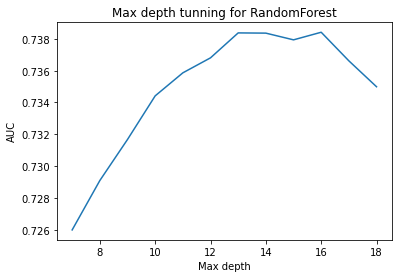

In [22]:
#RF calibration
aucs_cal_rf = []
depths = [7,8,9,10 ,11, 12 ,13 ,14 ,15 ,16 ,17 ,18]
for i in depths:
    model_rf = RandomForestClassifier(n_estimators=100, max_depth=i, random_state=0)
    model_rf_res = model_rf.fit(x_train , y_train) 
    predict_rf = model_rf_res.predict_proba(x_test)
    roc_rf = roc_curve(y_test , predict_rf[:,1])
    auc_rf = auc( roc_rf[0], roc_rf[1] )    
    aucs_cal_rf.append(auc_rf)
print('Best depth: ' ,depths[np.argmax(aucs_cal_rf)])
print('Best AUC: ', max(aucs_cal_rf))
sns.lineplot( depths ,aucs_cal_rf)
plt.xlabel('Max depth')
plt.ylabel('AUC')
plt.title('Max depth tunning for RandomForest')

The tunning shows that the best max depth for the random forest model is **16**.

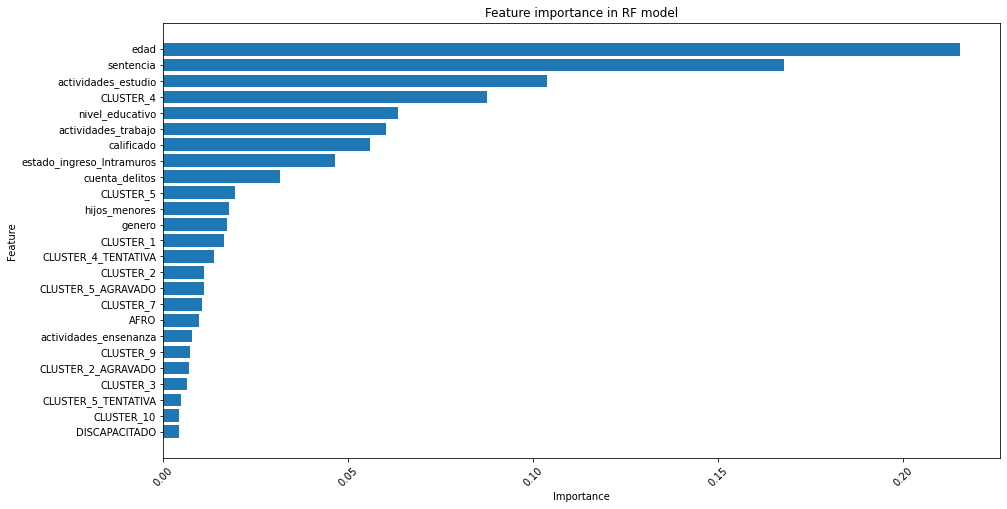

In [46]:
#RF (calibrated) feature importance
model_rf = RandomForestClassifier(n_estimators=100, max_depth= 16, random_state=0).fit(x_train , y_train) 
feature_importances = pd.DataFrame(
    model_rf.feature_importances_,
    index = x_train.columns ,
    columns=['importance'])
    
feature_importances = feature_importances.sort_values(['importance'], ascending=True)
plt.figure(figsize=(15,8))
plt.barh(feature_importances.index , feature_importances['importance'])
plt.xticks(rotation=45)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature importance in RF model')
plt.show()

In [25]:
#Random Forest cv
cv = StratifiedKFold(20)    
aucs_rf = []
thresh_rf = []
tprs_rf = []
mean_fpr_rf = np.linspace(0, 1, 100)
for train, test in cv.split(x , y):
    model_rf = RandomForestClassifier(n_estimators=100, max_depth=16, random_state=0).fit(x.iloc[train] , y.iloc[train]) 
    predict_rf = model_rf.predict_proba(x.iloc[test])
    roc_rf = roc_curve(y.iloc[test] , predict_rf[:,1])
    auc_rf = auc( roc_rf[0], roc_rf[1] )    
    #Stores all the points of the roc curve
    tprs_rf.append(np.interp(mean_fpr_rf, roc_rf[0], roc_rf[1]))
    tprs_rf[-1][0] = 0.0
    thresh_rf.append(roc_rf[2][np.argmax(roc_rf[1] - roc_rf[0])])
    aucs_rf.append(auc_rf)   
print('Crossvalidated average AUC: ' , np.mean(aucs_rf))
print('Optimal mean threshold: ' , np.mean(thresh_rf))

Crossvalidated average AUC:  0.7339049790631331
Optimal mean threshold:  0.4800452241290138


---
***Gradient Boosting***

In [26]:
parameters_gb = {'learning_rate':[0.05, 0.075, 0.1, 0.25, 0.5] , 'max_depth':[2,3,4,5,6,7,8,9,10]}
model_gb =  GradientBoostingClassifier(n_estimators= 50, max_features = None, random_state=0  )
tunning = GridSearchCV(model_gb, parameters_gb , cv= 3 , verbose = 4 ,n_jobs = -1)
tunning.fit(x_train, y_train)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  3.9min finished


GridSearchCV(cv=3,
             estimator=GradientBoostingClassifier(n_estimators=50,
                                                  random_state=0),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.075, 0.1, 0.25, 0.5],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
             verbose=4)

In [27]:
#scores = [x[1] for x in tunning.cv_results_]
print(tunning.best_params_)
print(tunning.best_score_)

{'learning_rate': 0.075, 'max_depth': 6}
0.6750904476483611


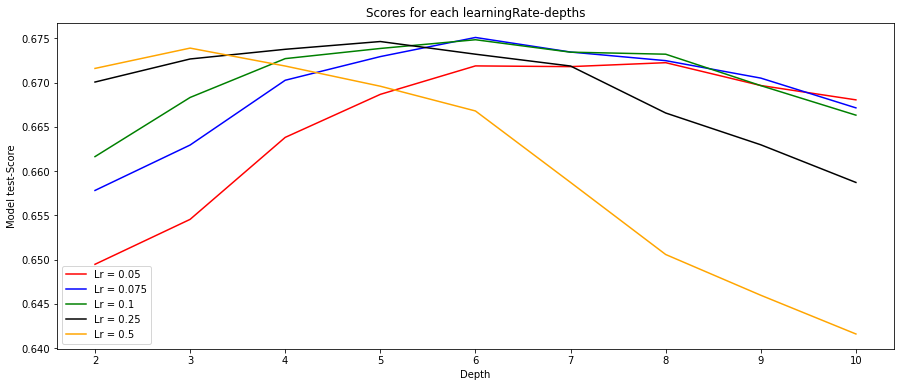

In [28]:
#Captures the average scores of the grid search and reshapes them according to the parameters used in the search
scores = tunning.cv_results_['mean_test_score']
scores = np.array(scores).reshape(len(parameters_gb.get('learning_rate')),len(parameters_gb.get('max_depth')))

#Plots a curve for each learning rate used vs max depth
colors = ['red', 'blue' , 'green' , 'black' , 'orange']
plt.figure(figsize=(15,6))
for i , val in enumerate(parameters_gb.get('learning_rate')):
          sns.lineplot( parameters_gb.get('max_depth') , scores[i,:] , color = colors[i] , label = f'Lr = {val}')
plt.xlabel('Depth')
plt.ylabel('Model test-Score')
plt.title('Scores for each learningRate-depths')
plt.legend(loc='lower left')
plt.show()

The tunning shows that the best params ofr the GradienBoosting model are  learning rate =  **0.075** and  max_depth = **6**

In [31]:
#Gradient bosting using the best parameters
model_gb = GradientBoostingClassifier(n_estimators= 100, learning_rate = 0.075 , max_features = None, max_depth= 6 , random_state=0 )
model_gb.fit(x_train, y_train)
pred_gb = model_gb.predict_proba(x_test)
roc_gb = roc_curve(y_test ,  pred_gb[:,1]  )
auc_gb = auc(roc_gb[0],roc_gb[1])
auc_gb

0.7424456136381659

In [32]:
#Gradient boosting cv (using the best hyperparameters)
cv = StratifiedKFold(20)    
aucs_gb = []
thresh_gb = []
tprs_gb = []
mean_fpr_gb = np.linspace(0, 1, 100)
for train, test in cv.split(x , y):
    model_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.075 , max_features= None, max_depth=6, random_state=0).fit(x.iloc[train] , y.iloc[train])
    pred_gb = model_gb.predict_proba(x.iloc[test])
    roc_gb = roc_curve(y.iloc[test],  pred_gb[:,1] )
    auc_gb = auc(roc_gb[0] , roc_gb[1] )
    #Stores all the points of the roc curve
    tprs_gb.append(np.interp(mean_fpr_gb, roc_gb[0], roc_gb[1]))
    tprs_gb[-1][0] = 0.0
    thresh_gb.append(roc_gb[2][np.argmax(roc_gb[1] - roc_gb[0])])
    aucs_gb.append(auc_gb)
print('Crossvalidated average AUC: ' , np.mean(aucs_gb))
print('Optimal mean threshold: ' , np.mean(thresh_gb))

Crossvalidated average AUC:  0.7371975529310999
Optimal mean threshold:  0.4728899103711185


---
***Xgbost Classifier***

In [33]:
parameters_xgb = {'eta':[0.05 , 0.1, 0.3]  , 'gamma':[0.1,0.2,0.3,0.4] , 'max_depth':[2,3,4,5,6,7]}
model_xgb = xgb.XGBClassifier(objective= 'binary:logistic', random_state=0)
tunning_xgb = GridSearchCV(model_xgb, parameters_xgb , cv= 3 , verbose = 4 ,n_jobs = -1)
tunning_xgb.fit(x_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  6.2min finished


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=0,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, va

In [34]:
print(tunning_xgb.best_params_)
print(tunning_xgb.best_score_)

{'eta': 0.1, 'gamma': 0.3, 'max_depth': 6}
0.6753469409795345


In [35]:
#Captures the average scores of the grid search and reshapes them according to the parameters used in the search
scores_xgb = tunning_xgb.cv_results_['mean_test_score']
scores_xgb = np.array(scores_xgb).reshape(len(parameters_xgb.get('eta')),len(parameters_xgb.get('gamma')),len(parameters_xgb.get('max_depth')))

In [13]:
#Feature importance
model_xgb = xgb.XGBClassifier(objective= 'binary:logistic', random_state=0 , eta = 0.1 , max_depth = 6 , gamma = 0.3 ).fit(x_train , y_train )

feature_importances = pd.DataFrame(
    model_rf.feature_importances_,
    index = x_train.columns ,
    columns=['importance'])

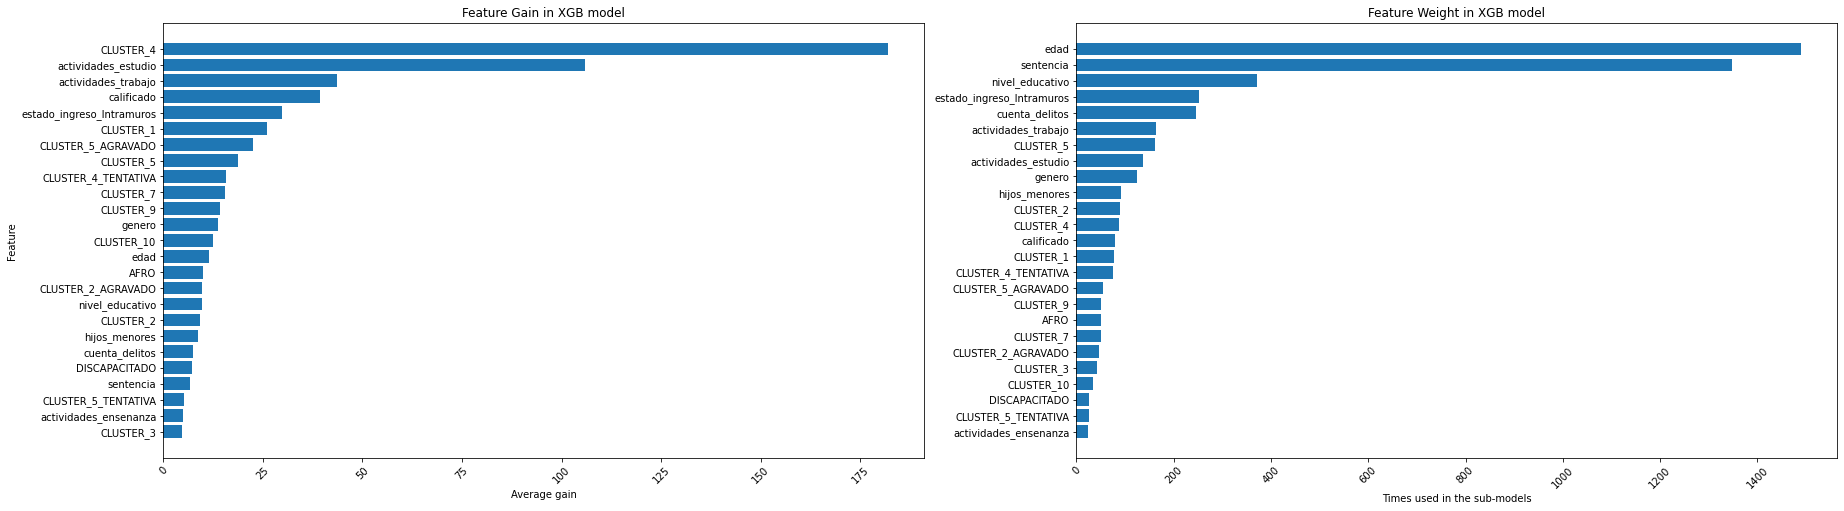

In [55]:
featureGain = pd.DataFrame.from_dict(model_xgb.get_booster().get_score(importance_type='gain'), orient='index' ,  columns=['Gain']).sort_values(['Gain'], ascending=True)
featureWeight = pd.DataFrame.from_dict(model_xgb.get_booster().get_score(importance_type='weight'), orient='index' ,  columns=['Weight']).sort_values(['Weight'], ascending=True)

plt.figure(figsize=(30,8))
plt.subplot(1,2,1)
plt.barh(featureGain.index , featureGain['Gain'])
plt.xticks(rotation=45)
plt.xlabel('Average gain')
plt.ylabel('Feature')
plt.title('Average feature Gain in XGB model')

plt.subplot(1,2,2)
plt.barh(featureWeight.index , featureWeight['Weight'])
plt.xticks(rotation=45)
plt.xlabel('Times used in the sub-models')
plt.ylabel('')
plt.title('Feature Weight in XGB model')
plt.show()

In [51]:
featureWeight['Weight']

actividades_ensenanza          23
CLUSTER_5_TENTATIVA            25
DISCAPACITADO                  25
CLUSTER_10                     34
CLUSTER_3                      42
CLUSTER_2_AGRAVADO             47
CLUSTER_7                      50
AFRO                           50
CLUSTER_9                      51
CLUSTER_5_AGRAVADO             55
CLUSTER_4_TENTATIVA            75
CLUSTER_1                      78
calificado                     80
CLUSTER_4                      88
CLUSTER_2                      89
hijos_menores                  91
genero                        124
actividades_estudio           137
CLUSTER_5                     162
actividades_trabajo           163
cuenta_delitos                246
estado_ingreso_Intramuros     253
nivel_educativo               371
sentencia                    1348
edad                         1490
Name: Weight, dtype: int64

The XGB model feature weights show that Age and Sentence leght are by far the features that the sub-models inside XGB use the most to classify the recidivist/non recidivist individuals. Other features like Education level and Intramuros state are also frequnetly used to predict the probability of recidivism.

In [36]:
#Xbost classifier cv using the best parameters found
cv = StratifiedKFold(20)    
aucs_xgb = []
thresh_xgb = []
tprs_xgb = []
mean_fpr_xgb = np.linspace(0, 1, 100)
for train, test in cv.split(x , y):
    model_xgb = xgb.XGBClassifier(objective= 'binary:logistic', random_state=0 , eta = 0.1 , max_depth = 6 , gamma = 0.3 ).fit(x.iloc[train] , y.iloc[train] )
    pred_xgb = model_xgb.predict_proba(x.iloc[test])
    roc_xgb = roc_curve(y.iloc[test],  pred_xgb[:,1]  )
    auc_xgb = auc(roc_xgb[0] , roc_xgb[1] )
    #Stores all the points of the roc curve
    tprs_xgb.append(np.interp(mean_fpr_xgb, roc_xgb[0], roc_xgb[1]))
    tprs_xgb[-1][0] = 0.0
    thresh_xgb.append(roc_xgb[2][np.argmax(roc_xgb[1] - roc_xgb[0])])
    aucs_xgb.append(auc_xgb)
print('Crossvalidated average AUC: ' , np.mean(aucs_xgb))
print('Optimal mean threshold: ' , np.mean(thresh_xgb))

Crossvalidated average AUC:  0.7368472304677531
Optimal mean threshold:  0.47917312


---

**Model performance comparison**

<Figure size 432x288 with 0 Axes>

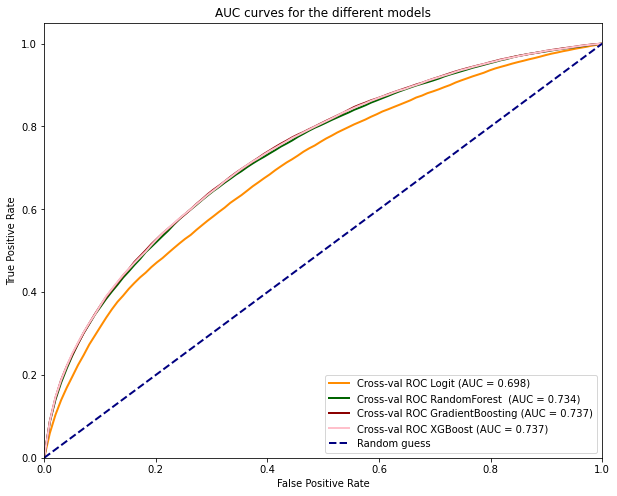

In [47]:
#Calculates the average curves using the cv outputs for each model
#Logit
mean_tpr_Logit = np.mean(tprs_Logit, axis=0)
mean_tpr_Logit[-1] = 1.0
#Rf
mean_tpr_rf = np.mean(tprs_rf , axis=0)
mean_tpr_rf[-1] = 1.0
#Gb
mean_tpr_gb = np.mean(tprs_gb , axis=0)
mean_tpr_gb[-1] = 1.0
#Xgb
mean_tpr_xgb = np.mean(tprs_xgb , axis=0)
mean_tpr_xgb[-1] = 1.0

#Plot the different curves
plt.figure()
plt.figure(figsize=(10,8))
line_width = 2
plt.plot(mean_fpr_Logit, mean_tpr_Logit, color='darkorange', lw=line_width,
         label=f"Cross-val ROC Logit (AUC = {np.mean(aucs_Logit):0.3f})")

plt.plot(mean_fpr_rf,  mean_tpr_rf, color='darkgreen', lw=line_width,
         label=f"Cross-val ROC RandomForest  (AUC = {np.mean(aucs_rf):0.3f})")

plt.plot(mean_fpr_gb,mean_tpr_gb , color='darkred', lw=line_width,
        label=f"Cross-val ROC GradientBoosting (AUC = {np.mean(aucs_gb):0.3f})")

plt.plot(mean_fpr_xgb, mean_tpr_xgb, color='pink', lw=line_width,
         label=f"Cross-val ROC XGBoost (AUC = {np.mean(aucs_xgb):0.3f})")

plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC curves for the different models')
plt.legend(loc='lower right')
plt.show()

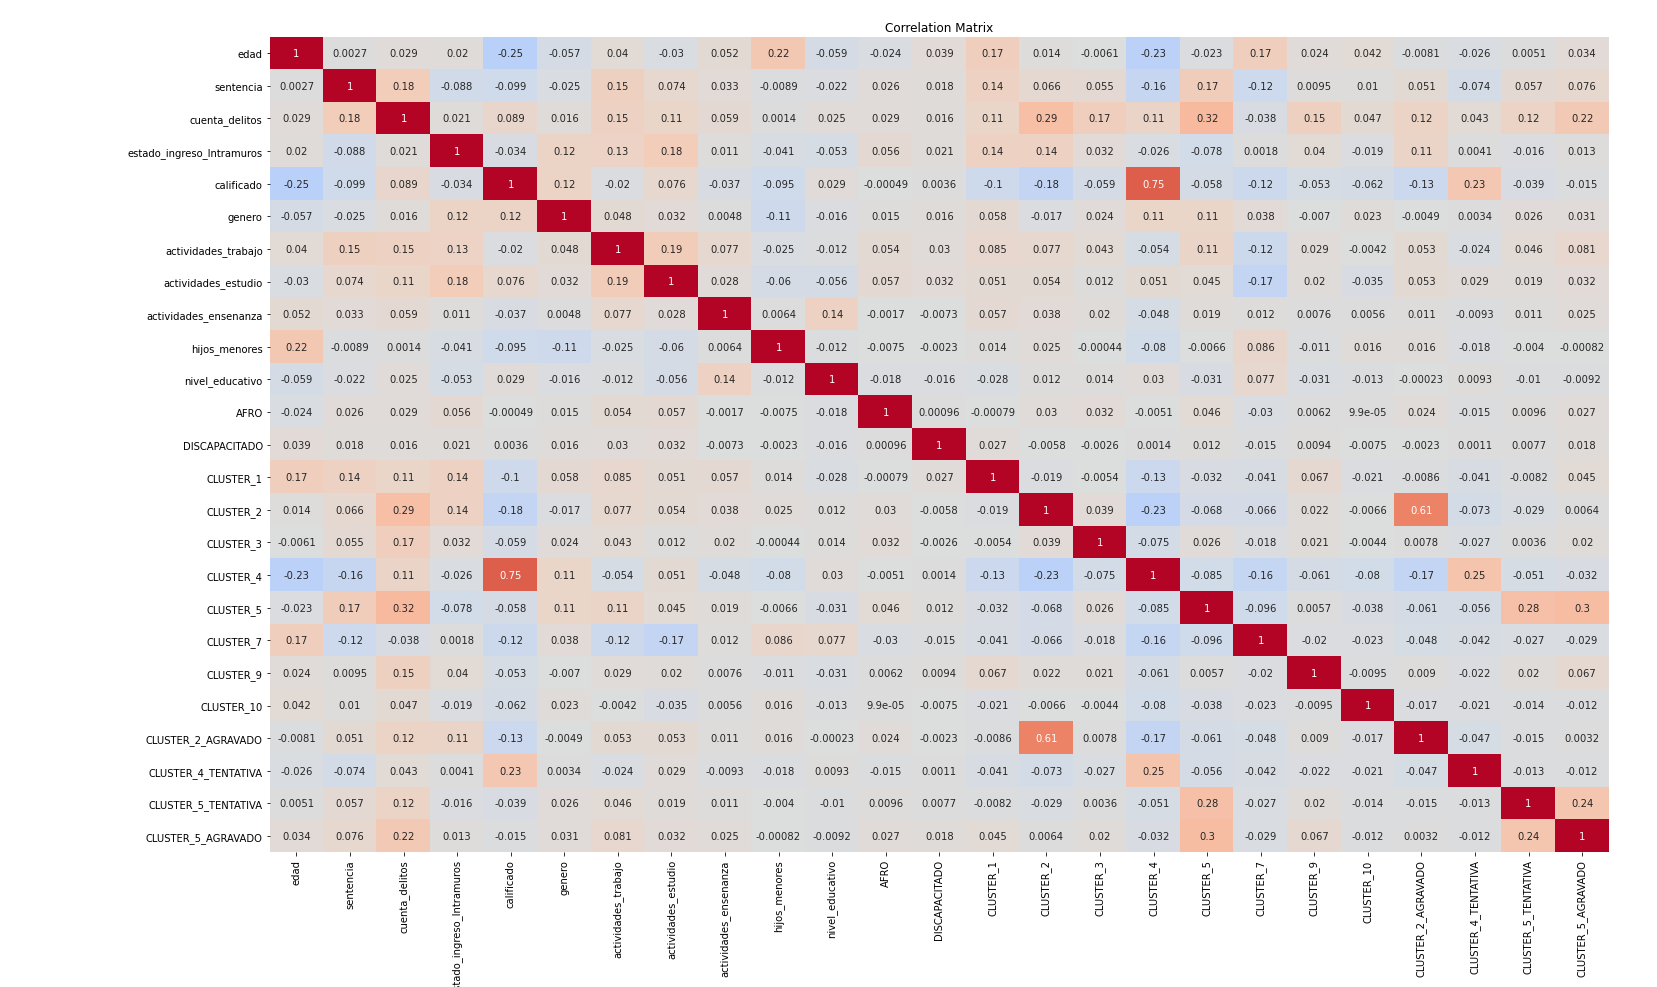

In [48]:
corr_mat = x_train.corr()
plt.figure(figsize=(30,15))
sns.heatmap(corr_mat,  cmap= 'coolwarm' ,   vmin = -1, vmax = 1, center= 0, annot = True)
plt.title("Correlation Matrix")
plt.show()

In [39]:
#Model reduced for dash
vars_selected = ['edad',
                'sentencia',
                'actividades_estudio',
                'CLUSTER_4',
                'actividades_trabajo',
                'calificado',
                'nivel_educativo',
                'estado_ingreso_Intramuros',
                'cuenta_delitos', 
                'agravado',
                'CLUSTER_5',
                'CLUSTER_1',
                'genero'
                #'hijos_menores',
                #'tentativa',
                #'actividades_ensenanza', 
                #'AFRO',
                #'CLUSTER_2', 'CLUSTER_3', 'CLUSTER_7','CLUSTER_9','CLUSTER_10',
                #'DISCAPACITADO'
                ]

#Standarizre x and split in train and test
#x = (df_models[vars_selected]-df_models[vars_selected].mean())/df_models[vars_selected].std()
x = df_models[vars_selected]
y = df_balanced['reincidente']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2 , random_state=0 , stratify= y)

print('Train: ', x_train.shape)
print('Test: ', x_test.shape)

Train:  (74076, 13)
Test:  (18520, 13)


In [40]:
model_xgb_dash = xgb.XGBClassifier(objective= 'binary:logistic', random_state=0 , eta = 0.1 , max_depth = 5 , gamma = 0.4 ).fit(x_train ,y_train )
pred_xgb_dash = model_xgb_dash.predict_proba(x_test)
roc_xgb_dash = roc_curve(y_test , pred_xgb_dash[:,1]  )
auc_xgb_dash = auc(roc_xgb_dash[0] , roc_xgb_dash[1] )

In [41]:
auc_xgb_dash

0.7354807481492194

In [42]:
#Saves the ebst model to be used later in the appi
pickle.dump( model_xgb_dash   , open("Model_dash.pickle","wb"))

---
Funciones para el dash

In [43]:
##Leer modelo
import pickle
modelo_dash = pickle.load(open("Model_dash.pickle","rb"))

## Predecir dados los inputs
def pred_reincidente(model , x ):
    pred = model.predict_proba(x)
    return pred[:,0] , pred[:,1]


#Info de las varibles:  
#edad (entero ), sentencia (float),  actividades_estudio (0 = No , 1 = Si) ,   CLUSTER_4 ( 0 = No , 1 = Si ) ,   actividades_trabajo (0 = No , 1 = Si),   calificado( 0 = No , 1 = Si), nivel_educativo( 0 = 'ANALFABETA', 1=  'CICLO I', 2= 'CICLO II', 3=  'CICLO III', 4= 'CICLO IV',5= 'TECNOLOGICO', 6 = 'TECNICO', 7 = 'TECNICO PROFESIONAL', 8 ='PROFESIONAL', 9 ='POST GRADO', 10 = 'ESPECIALIZACION', 11 =  'MAGISTER'),
# estado_ingreso_Intramuros(0 = No , 1 = Si) , cuenta_delitos (entero entre 1 y 20), agravado (0 = No , 1 = Si) ,    CLUSTER_5 (0 = No , 1 = Si), CLUSTER_1 (0 = No , 1 = Si), genero ( 0 = Femenino , 1 = Masculino)


datos_x = pd.DataFrame({'edad' :[30], 'sentencia':[5.5], 'actividades_estudio':[0], 'CLUSTER_4':[1], 'actividades_trabajo':[1], 'calificado':[1], 'nivel_educativo':[4], 'estado_ingreso_Intramuros':[1], 'cuenta_delitos':[3], 'agravado':[1], 'CLUSTER_5':[0], 'CLUSTER_1':[0], 'genero':[1]} )



#Retorna proba de no ser reincidente y de ser reincidente
pred_reincidente(modelo_dash ,datos_x )

(array([0.30466592], dtype=float32), array([0.6953341], dtype=float32))